# Wind rose data

Here we demonstrate how mean results over wind rose data are calculated in `foxes`. We need the following imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC

First, we setup the model book and the wind farm. We choose 6 x 5 turbines on a regular grid:

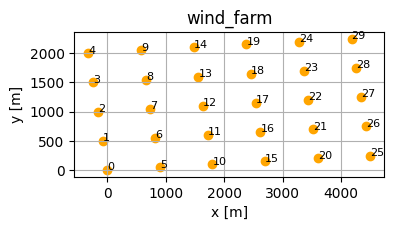

In [2]:
mbook = foxes.ModelBook()

farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm=farm,
    xy_base=[0.0, 0.0],
    step_vectors=[[900.0, 50.0], [-80., 500.0]],
    steps=[6, 5],
    turbine_models=["NREL5MW", "kTI_05"],
    verbosity=0
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(4, 3))
plt.show()

Next, we create the states based on the static data file `wind_rose_bremen.csv.gz`. The data represents a (coarse) wind rose with 216 states. Each of them consists of the wind direction and wind speed bin centres, and the respective statistical weight of the bin (normalized such that 1 represents 100%):
```
state,wd,ws,weight
0,0.0,3.5,0.00158
1,0.0,6.0,0.00244
2,0.0,8.5,0.00319
3,0.0,12.5,0.0036700002
4,0.0,17.5,0.00042
...
```
Let's create the states object and have a look at the wind rose:

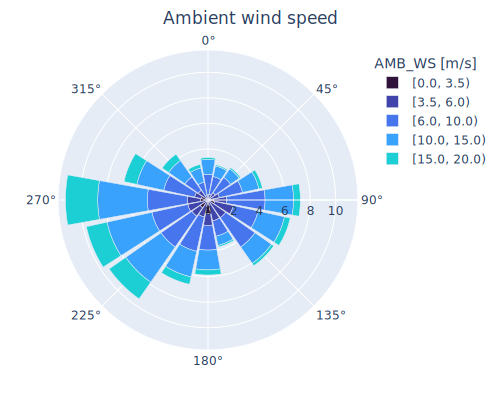

In [3]:
states = foxes.input.states.StatesTable(
    data_source="wind_rose_bremen.csv",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.WEIGHT: "weight"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20])
fig.show("svg")

We can now setup our algorithm. In this example, we invoke one wake model for the wind deficit, `Bastankhah_linear` (with linear wake superposition), and another for the turbulence intensity wake effect, `CrespoHernandez_max` (with maximum wake superposition). Both obtain the wake growth parameter `k` by a relation `k = 0.5 * TI`, see `turbine_models` choice in the wind farm setup.

In [4]:
algo = foxes.algorithms.Downwind(
    mbook,
    farm,
    states=states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_linear", "CrespoHernandez_max"],
    wake_frame="rotor_wd",
    partial_wakes_model="auto",
    chunks={FC.STATE: 500, FC.POINT: 4000},
    verbosity=0,
)

We can now calculate the results:

[                                        ] | 0% Completed | 208.64 us

[########################################] | 100% Completed | 101.89 ms

[                                        ] | 0% Completed | 270.02 us

[                                        ] | 0% Completed | 103.26 ms

[########################################] | 100% Completed | 204.96 ms

Efficiency added to farm results


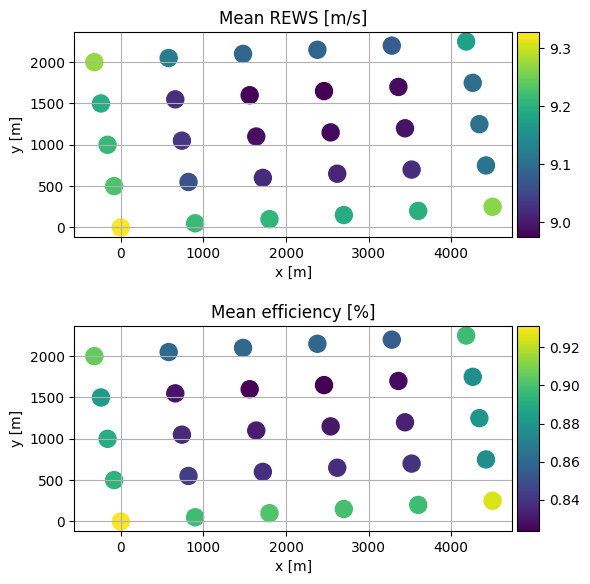


Farm power        : 78.0 MW
Farm ambient power: 81.7 MW
Farm efficiency   : 95.46 %
Annual farm yield : 683.48 GWh


In [5]:
with foxes.utils.runners.DaskRunner() as runner:
    farm_results = runner.run(algo.calc_farm)

o = foxes.output.FarmResultsEval(farm_results)
o.add_efficiency()

fig, axs = plt.subplots(2,1,figsize=(6, 7))
o = foxes.output.FarmLayoutOutput(farm, farm_results)
o.get_figure(fig=fig, ax=axs[0], color_by="mean_REWS", title="Mean REWS [m/s]", s=150, annotate=0)
o.get_figure(fig=fig, ax=axs[1], color_by="mean_EFF", title="Mean efficiency [%]", s=150, annotate=0)
plt.show()

o = foxes.output.FarmResultsEval(farm_results)
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power        : {P/1000:.1f} MW")
print(f"Farm ambient power: {P0/1000:.1f} MW")
print(f"Farm efficiency   : {o.calc_farm_efficiency()*100:.2f} %")
print(f"Annual farm yield : {o.calc_farm_yield(algo=algo):.2f} GWh")

Finally, we display the mean wind speed field as a 2D plot, including wake effects. We could simply do this by

```python
o = foxes.output.FlowPlots2D(algo, farm_results)
o.get_mean_fig_xy(FV.WS, resolution=30)
plt.show()
```

This is perfectly fine, but if we wish to see a progress bar and have additional options for the parallel run on a cluster (which we are not using here), the output function should instead be passed to a `DaskRunner` object:

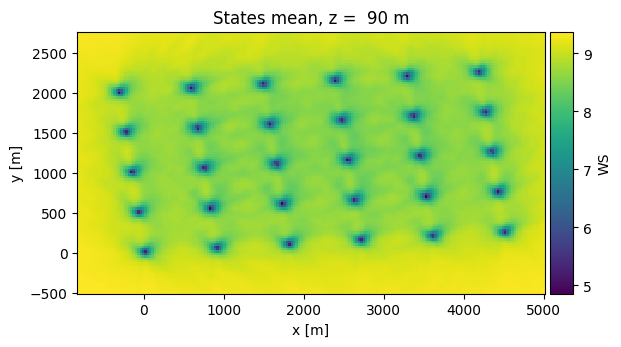

In [6]:
with foxes.utils.runners.DaskRunner() as runner:
    o = foxes.output.FlowPlots2D(algo, farm_results, runner=runner)
    o.get_mean_fig_xy(FV.WS, resolution=30)
    plt.show()

Note that for the vectorization/parallelization to work we need to set the `chunks` arguments in the creation of the `Algorithm` object. Here chunks of 4000 points were calculated at a time (for all states).